# Source:

https://www.kaggle.com/code/sumantindurkhya/topic-modeling-on-20-newsgroup-data-lsa-and-lda

# Topic modeling on 20 news group data set

## Import libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import re
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
# from jupytertehmes import jtplot

import umap
from sklearn.decomposition import TruncatedSVD, PCA, NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim import corpora
from gensim.models.ldamodel import LdaModel

In [ ]:
# set plot rc parameters

# jtplot.style(grid=False)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#464646'
#plt.rcParams['axes.edgecolor'] = '#FFFFFF'
plt.rcParams['figure.figsize'] = 10, 7
plt.rcParams['text.color'] = '#666666'
plt.rcParams['axes.labelcolor'] = '#666666'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.color'] = '#666666'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.color'] = '#666666'
plt.rcParams['ytick.labelsize'] = 14

# plt.rcParams['font.size'] = 16

sns.color_palette('dark')
%matplotlib inline

## Load data

In [ ]:
# Load news data set
# remove meta data headers footers and quotes from news dataset
dataset = fetch_20newsgroups(shuffle=True,
                            random_state=32,
                            remove=('headers', 'footers', 'qutes'))

In [ ]:
# sneak peek of the news articles
for idx in range(10):
    print(dataset.data[idx],'\n\n','#'*100, '\n\n')

The real question here in my opinion is what Motorola processors running system
7 on a MAC are comparable to what Intel processors running Windows on a PC?  I
recall there being a conversation here that a 486/25 running Windows benchmarks
at about the same speed as 25Mhz 030 in system 7.  I don't know if that is
true, but I would love to hear if anyone has any technical data on this.

-David 

 #################################################################################################### 


Please could someone in the US give me the current street 
prices on the following, with and without any relevant taxes:

 8 Mb 72 pin SIMM
16 Mb 72 pin SIMM (both for Mac LC III)

Are any tax refunds possible if they are to be exported
to the UK? Can you recommend a reliable supplier? 

 #################################################################################################### 


Can somebody please help me with information about an
American Magnetics Corporation Magstripe Card Read

In [ ]:
# put your data into a dataframe
news_df = pd.DataFrame({'News': dataset.data,
                       'Target': dataset.target})

# get dimensions of data
news_df.shape

(11314, 2)

In [ ]:
news_df.head()

,News,Target
0,The real question here in my opinion is what M...,4
1,Please could someone in the US give me the cur...,4
2,Can somebody please help me with information a...,12
3,In article <2077@rwing.UUCP> pat@rwing.UUCP (P...,16
4,"From article <1pq6i2$a1f@news.ysu.edu>, by ak2...",7


In [ ]:
# replace target names from target numbers in our news data frame
news_df['Target_name'] = news_df['Target'].apply(lambda x: dataset.target_names[x])

In [ ]:
news_df.head()

,News,Target,Target_name
0,The real question here in my opinion is what M...,4,comp.sys.mac.hardware
1,Please could someone in the US give me the cur...,4,comp.sys.mac.hardware
2,Can somebody please help me with information a...,12,sci.electronics
3,In article <2077@rwing.UUCP> pat@rwing.UUCP (P...,16,talk.politics.guns
4,"From article <1pq6i2$a1f@news.ysu.edu>, by ak2...",7,rec.autos


*  This Exercise is for understanding Topic modeling and we wont be needing Target and Target names for that
*  You guys can try other problems like multilabel classification on this dataset; plenty of resources are available for that
*  Some of the example problems are available on [sklearns website](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html)

### Distribution of Topics

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text xticklabel objects>)

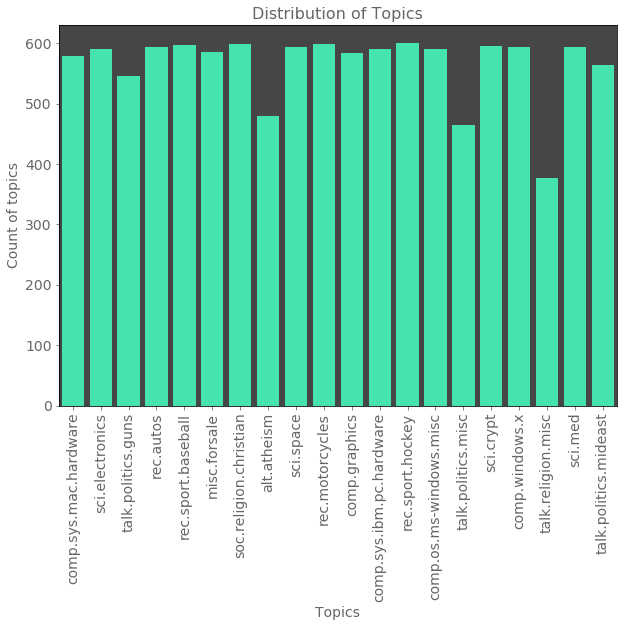

In [ ]:
# plot distribution of topics in news data
fig = plt.figure(figsize=[10,7])
ax = sns.countplot(news_df['Target_name'], color=sns.xkcd_rgb['greenish cyan'])
plt.title('Distribution of Topics')
plt.xlabel('Topics')
plt.ylabel('Count of topics')
plt.xticks(rotation=90)

*  All the articles are almost uniformly ditributed among 20 topics

## Text preprocessing

In [ ]:
# clean text data
# remove non alphabetic characters
# remove stopwords and lemmatize

def clean_text(sentence):
    # remove non alphabetic sequences
    pattern = re.compile(r'[^a-z]+')
    sentence = sentence.lower()
    sentence = pattern.sub(' ', sentence).strip()

    # Tokenize
    word_list = word_tokenize(sentence)

    # stop words
    stopwords_list = set(stopwords.words('english'))
    # puctuation
    # punct = set(string.punctuation)

    # remove stop words
    word_list = [word for word in word_list if word not in stopwords_list]
    # remove very small words, length < 3
    # they don't contribute any useful information
    word_list = [word for word in word_list if len(word) > 2]
    # remove punctuation
    # word_list = [word for word in word_list if word not in punct]

    # stemming
    # ps  = PorterStemmer()
    # word_list = [ps.stem(word) for word in word_list]

    # lemmatize
    lemma = WordNetLemmatizer()
    word_list = [lemma.lemmatize(word) for word in word_list]
    # list to sentence
    sentence = ' '.join(word_list)

    return sentence

# we'll use tqdm to monitor progress of data cleaning process
# create tqdm for pandas
tqdm.pandas()
# clean text data
news_df['News'] = news_df['News'].progress_apply(lambda x: clean_text(str(x)))

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 11314/11314 [00:33<00:00, 336.02it/s]


In [ ]:
news_df.head()

,News,Target,Target_name
0,real question opinion motorola processor runni...,4,comp.sys.mac.hardware
1,please could someone give current street price...,4,comp.sys.mac.hardware
2,somebody please help information american magn...,12,sci.electronics
3,article rwing uucp pat rwing uucp pat myrto wr...,16,talk.politics.guns
4,article news ysu edu yfn ysu edu john daker cu...,7,rec.autos


### WordCloud of processed text

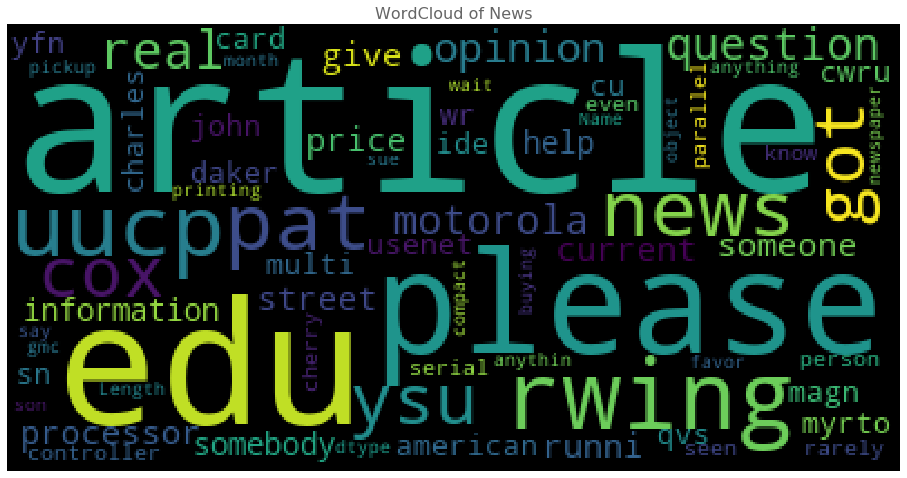

In [ ]:
# plot word count for news text
wordcloud = WordCloud(background_color='black',
                      max_words=200).generate(str(news_df['News']))
fig = plt.figure(figsize=[16,16])
plt.title('WordCloud of News')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

*  not very useful, isn't it?

### Featurize News article

*  we'll use TF-IDF vectorizer
*  it is also sometimes reffered as document-term matrix

In [ ]:
# vectorize text data
tfid_vec = TfidfVectorizer(tokenizer=lambda x: str(x).split())
X = tfid_vec.fit_transform(news_df['News'])
X.shape

(11314, 73153)

### Visualize news vectors

#### PCA

In [ ]:
# # PCA
# pca = PCA(n_components=2)
# pca.fit(X)
# pc1, pc2 = pca.transform(X)
# # plot news vectors
# ax = sns.scatterplot(pc1, pc2, hue=news_df['Target_name'])
# plt.show()

# pca doesn't take sparse input

#### t-SNE

In [ ]:
# t-SNE
tsne = TSNE(n_components=2,
           perplexity=50,
           learning_rate=300,
           n_iter=800,
           verbose=1)
# tsne to our document vectors
componets = tsne.fit_transform(X)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 11314 samples in 0.004s...
[t-SNE] Computed neighbors for 11314 samples in 14.075s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11314
[t-SNE] Computed conditional probabilities for sample 2000 / 11314
[t-SNE] Computed conditional probabilities for sample 3000 / 11314
[t-SNE] Computed conditional probabilities for sample 4000 / 11314
[t-SNE] Computed conditional probabilities for sample 5000 / 11314
[t-SNE] Computed conditional probabilities for sample 6000 / 11314
[t-SNE] Computed conditional probabilities for sample 7000 / 11314
[t-SNE] Computed conditional probabilities for sample 8000 / 11314
[t-SNE] Computed conditional probabilities for sample 9000 / 11314
[t-SNE] Computed conditional probabilities for sample 10000 / 11314
[t-SNE] Computed conditional probabilities for sample 11000 / 11314
[t-SNE] Computed conditional probabilities for sample 11314 / 11314
[t-SNE] Mean sigma: 0.503419
[t-SNE] KL divergen

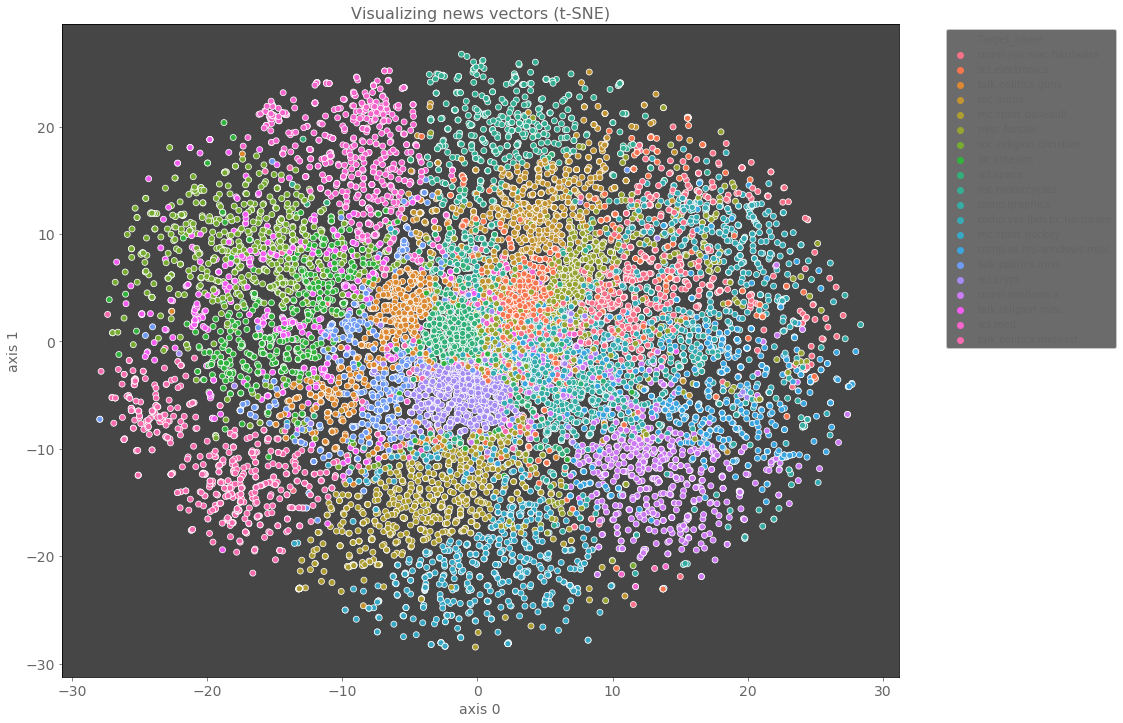

In [ ]:
# plot news vectors
def plot_embeddings(embedding, title):
    fig = plt.figure(figsize=[15,12])
    ax = sns.scatterplot(embedding[:,0], embedding[:,1], hue=news_df['Target_name'])
    plt.title(title)
    plt.xlabel('axis 0')
    plt.ylabel('axis 1')
    plt.legend(bbox_to_anchor=(1.05,1), loc=2)
    plt.show()
    return

plot_embeddings(componets, 'Visualizing news vectors (t-SNE)')

#### Umap

In [ ]:
# # get umap embeddings
# engine = umap.UMAP(n_components=2,
#                    n_neighbors=150,
#                    min_dist=0.7)
# # fit data
# embedding = engine.fit_transform(X)

# # plot umap embeddings
# plot_embeddings(embedding, 'Visualizing news vectors UMAP')

*  PCA can't be used for sparse data
*  There is some issue with umap implementation
*  so we'll use t-SNE for our analysis

## Topic model

### Latent Semantic Analysis (LSA)

In [ ]:
# create svd instance
svd_model = TruncatedSVD(n_components=20,
                         random_state=12,
                         n_iter=100,
                         algorithm='randomized')

# fit model to data
svd_model.fit(X)

TruncatedSVD(algorithm='randomized', n_components=20, n_iter=100,
             random_state=12, tol=0.0)

In [ ]:
# topic word mapping martrix
svd_model.components_.shape

(20, 73153)

In [ ]:
# document topic mapping matrix
doc_topic = svd_model.fit_transform(X)
doc_topic.shape

In [ ]:
terms = tfid_vec.get_feature_names()
len(terms)

73153

#### map topics to terms

In [ ]:
# function to map words to topics
def map_word2topic(components, terms):
    # create output series
    word2topics = pd.Series()

    for idx, component in enumerate(components):
        # map terms (words) with topic
        # which is probability of word given a topic P(w|t)
        term_topic = pd.Series(component, index=terms)
        # sort values based on probability
        term_topic.sort_values(ascending=False, inplace=True)
        # put result in series output
        word2topics['topic '+str(idx)] = list(term_topic.iloc[:10].index)

    return word2topics

In [ ]:
word2topics = map_word2topic(svd_model.components_, terms)

# print topic results
print('Topics\t\tWords')
for idx, item in zip(word2topics.index, word2topics):
    print(idx,'\t',item)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


Topics		Words
topic 0 	 ['edu', 'would', 'one', 'writes', 'com', 'article', 'people', 'know', 'like', 'get']
topic 1 	 ['window', 'drive', 'card', 'file', 'thanks', 'driver', 'disk', 'scsi', 'program', 'system']
topic 2 	 ['god', 'window', 'jesus', 'christian', 'bible', 'file', 'faith', 'christ', 'belief', 'atheist']
topic 3 	 ['key', 'chip', 'encryption', 'clipper', 'government', 'escrow', 'system', 'phone', 'law', 'algorithm']
topic 4 	 ['drive', 'scsi', 'ide', 'disk', 'controller', 'hard', 'floppy', 'card', 'bus', 'god']
topic 5 	 ['game', 'god', 'key', 'team', 'player', 'chip', 'jesus', 'hockey', 'play', 'season']
topic 6 	 ['edu', 'com', 'writes', 'article', 'key', 'god', 'apr', 'chip', 'scsi', 'uiuc']
topic 7 	 ['window', 'drive', 'israel', 'israeli', 'file', 'scsi', 'armenian', 'game', 'team', 'arab']
topic 8 	 ['card', 'driver', 'car', 'video', 'window', 'monitor', 'com', 'gun', 'color', 'bus']
topic 9 	 ['card', 'israel', 'edu', 'israeli', 'arab', 'jew', 'video', 'please', 'th

*  Few topics have some kind pattern in the most likey words for that perticular topic but its not somthing amazing
*  we can say LSA does a decent job but not great job
*  it looks like we will do fairly well by reducing number of topics
*  may be checking target topics once again to find a good number topics will do the trick, may be I'll work on that in later version of this notebook

#### map document to topics and terms

In [ ]:
# get top3 topics for a news document
def get_top3_topics(x):
    top3 = list(x.sort_values(ascending=False).head(3).index) + list(x.sort_values(ascending=False).head(3).values)
    return top3

# map top3 topic words to news document
def map_topicword2doc(model, X):
    # output data frame column list
    cols = ['topic_'+str(i+1)+'_name' for i in range(3)] + ['topic_'+str(i+1)+'_prob' for i in range(3)]
    # doc to topic mapping
    doc_topic = model.fit_transform(X)
    # list of topics
    topics = ['topic'+str(i) for i in range(20)]
    # doc topic data frame
    doc_topic_df = pd.DataFrame(doc_topic, columns=topics)
    # map top 3 topics to doc
    outdf = doc_topic_df.progress_apply(lambda x: get_top3_topics(x), axis=1)
    # outdf is a series of list
    # convert it to a data frame
    outdf = pd.DataFrame(dict(zip(outdf.index, outdf.values))).T
    outdf.columns = cols

    return outdf

In [ ]:
top_topics = map_topicword2doc(svd_model, X)
news_topics = pd.concat([news_df, top_topics], axis=1)

100%|██████████| 11314/11314 [00:16<00:00, 684.35it/s]


In [ ]:
top_topics.shape, news_topics.shape

((11314, 6), (11314, 9))

In [ ]:
# convert probability from string to float
news_topics = news_topics.infer_objects()

In [ ]:
news_topics.head(10)

,News,Target,Target_name,topic_1_name,topic_2_name,topic_3_name,topic_1_prob,topic_2_prob,topic_3_prob
0,real question opinion motorola processor runni...,4,comp.sys.mac.hardware,topic1,topic0,topic17,0.171037,0.146475,0.0934564
1,please could someone give current street price...,4,comp.sys.mac.hardware,topic0,topic17,topic1,0.0739063,0.0506653,0.0466159
2,somebody please help information american magn...,12,sci.electronics,topic0,topic1,topic9,0.0721259,0.0710009,0.0695877
3,article rwing uucp pat rwing uucp pat myrto wr...,16,talk.politics.guns,topic0,topic3,topic16,0.0560895,0.0255999,0.0239465
4,article news ysu edu yfn ysu edu john daker cu...,7,rec.autos,topic0,topic8,topic16,0.135441,0.034782,0.0129423
5,article news cso uiuc edu cka uxa cso uiuc edu...,9,rec.sport.baseball,topic0,topic6,topic9,0.144548,0.105145,0.0687119
6,used equipment sale everything negotiable baud...,6,misc.forsale,topic4,topic1,topic0,0.228493,0.162075,0.100635
7,recently bought ram card original mac portable...,4,comp.sys.mac.hardware,topic0,topic1,topic8,0.144075,0.129421,0.115708
8,article apr athos rutgers edu cleveland freene...,15,soc.religion.christian,topic0,topic2,topic5,0.172222,0.104552,0.0383307
9,apr geneva rutgers edu jprzybyl skidmore edu w...,15,soc.religion.christian,topic0,topic6,topic2,0.108184,0.0571752,0.0156538


*  well If you compare topics assigned to an article with target names, it's really not that impressive

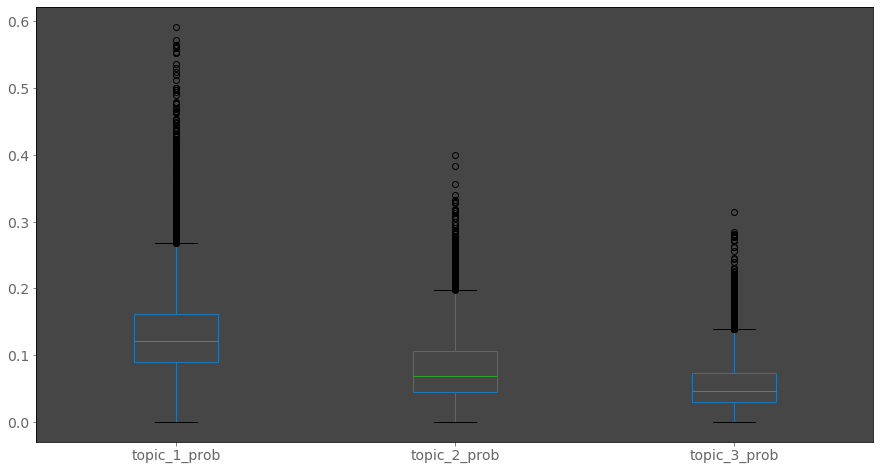

In [ ]:
# plot boxplot of top 3 topic scores to check their distribution
cols = ['topic_1_prob','topic_2_prob','topic_3_prob']
colors = [sns.xkcd_rgb['greenish cyan'], sns.xkcd_rgb['cyan'], sns.xkcd_rgb['reddish pink']]
fig = plt.figure(figsize=[15,8])
news_topics.boxplot(column=cols,
                   grid=False)
plt.show()

### Latent Dirichlet Allocation (LDA)

In [ ]:
# lda instance
lda_model = LatentDirichletAllocation(n_components=20,
                                     random_state=12,
                                     learning_method='online',
                                     max_iter=5,
                                     learning_offset=50)
# fit model
lda_model.fit(X)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=12, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [ ]:
lda_model.components_.shape

(20, 73153)

In [ ]:
doc_topic_lda = lda_model.transform(X)
doc_topic_lda.shape

(11314, 20)

In [ ]:
word2topics_lda = map_word2topic(lda_model.components_, terms)

# print topic results
print('Topics\t\tWords')
for idx, item in zip(word2topics_lda.index, word2topics_lda):
    print(idx,'\t',item)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


Topics		Words
topic 0 	 ['knbr', 'hillel', 'frisco', 'rubenstein', 'tudelft', 'ordularinin', 'simsh', 'kelbadjar', 'adventurer', 'sonra']
topic 1 	 ['burzynski', 'fdd', 'antineoplastons', 'taybh', 'oncologist', 'jschwimmer', 'glioblastoma', 'wccnet', 'schwimmer', 'stanislaw']
topic 2 	 ['max', 'mfc', 'harkey', 'wetteland', 'giz', 'bhj', 'csupomona', 'vmsb', 'oscs', 'vdoe']
topic 3 	 ['chigger', 'gainesville', 'rawley', 'eastwick', 'dynamo', 'alr', 'proveisa', 'alboum', 'farjestad', 'vantaa']
topic 4 	 ['edu', 'would', 'one', 'writes', 'com', 'article', 'know', 'like', 'get', 'people']
topic 5 	 ['judah', 'kindled', 'aantal', 'snijpunten', 'forsake', 'asa', 'clibsucces', 'puntbinnenpolygoon', 'polygoon', 'geefpolygoonrandpunt']
topic 6 	 ['compiliers', 'fisk', 'jburke', 'mcole', 'xgolf', 'qfe', 'swee', 'qzz', 'lyman', 'pppl']
topic 7 	 ['fettrons', 'trons', 'fetrons', 'verging', 'grechko', 'vetical', 'georgy', 'fet', 'wimp', 'anal']
topic 8 	 ['bilinsky', 'responces', 'nursery', 'ntfs',